# Online Retail - Customer Segmentation & Clustering
---

## Data Description:
---

### Data Set Information:

  This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Source: [Online-Retail](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

---

### Attribute Information:

- **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- **Description**: Product (item) name. Nominal.
- **Quantity**: The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.
- **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
- **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- **Country**: Country name. Nominal, the name of the country where each customer resides.

---

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# feature scaling
from sklearn.preprocessing import StandardScaler

# modeling
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# visualization
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## Data Exploration

In [2]:
# load dataset
data_path = "https://raw.githubusercontent.com/ezzaldeeen/customer-segmentation/main/Data/online-retail.csv"
data = pd.read_csv(data_path, parse_dates=['InvoiceDate'])
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [4]:
# shape of the dataset
data.shape

(541909, 8)

In [5]:
# informatino about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### Handling Missing Values

In [6]:
# shape of the data before cleaning
data.shape

(541909, 8)

In [7]:
# number of missings per column
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Here I decided to drop all the rows that didn't record the customer ID

In [8]:
# drop all NaN values
data.dropna(inplace=True)
# shape of the data after cleaning
data.shape

(406829, 8)

In [9]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Clean noisy data

In [10]:
# statistical description
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
print("% of the canceld transaction: ", data[data['Quantity']<=0].shape[0] / data.shape[0])

% of the canceld transaction:  0.021888803403887137


Here I want to remove the canceled transactions which are formed **2%** of the data, all these rows have *a negative quantity*

In [12]:
# remove the canceld transactions
canceld_transaction_indices = data[data['Quantity']<=0].index
data.drop(index=canceld_transaction_indices, axis='rows', inplace=True)
# shape after removing
data.shape

(397924, 8)

In [13]:
# statistical description
data.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


## Data Extraction

### The RFM model

- **Recency**: How recently a customer has made a purchase
- **Frequency**: How often a customer makes a purchase
- **Monetary** Value: How much money a customer spends on purchases

In [14]:
# compute the total price
data['total_price'] = data['UnitPrice'] * data['Quantity']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Compute the **monetary value**

In [15]:
# aggregate and compute the total payments per customer
customer_total_payments = data.groupby('CustomerID')['total_price'].sum()
customer_total_payments = customer_total_payments.rename('total_payment')
customer_total_payments = customer_total_payments.reset_index()
customer_total_payments.head()

,CustomerID,total_payment
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


Compute the **frequency**

In [16]:
customer_transactions = data.groupby('CustomerID')['InvoiceNo'].count()
customer_transactions = customer_transactions.rename('total_transactions')
customer_transactions = customer_transactions.reset_index()
customer_transactions.head()

,CustomerID,total_transactions
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Compute the **recency**

In [17]:
# compute the duration between the last transaction and all transactions
# for all customer and their transactions
data['duration'] = data['InvoiceDate'].max() - data['InvoiceDate']

# last transaction for the customer in days
customer_last_trans = data.groupby('CustomerID')['duration'].min().dt.days
customer_last_trans = customer_last_trans.rename('last_transaction')
customer_last_trans = customer_last_trans.reset_index()
customer_last_trans.head()

,CustomerID,last_transaction
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [18]:
# create new dataframe RFM
# that has Custo. ID, Recency, Frequency, and Montert Value for customers
rfm = pd.DataFrame()
rfm['CustomerID'] = customer_total_payments['CustomerID']
rfm['montery_value'] = customer_total_payments['total_payment']
rfm['frequency'] = customer_transactions['total_transactions']
rfm['recency'] = customer_last_trans['last_transaction']
rfm.head()

,CustomerID,montery_value,frequency,recency
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


### Feature Scaling

In [19]:
# exclude customer IDs
rfm_numeric = rfm[['montery_value', 'frequency',	'recency']]
rfm_numeric_standarized = StandardScaler().fit_transform(rfm_numeric)
rfm_numeric_standarized = pd.DataFrame(rfm_numeric_standarized, columns = rfm_numeric.columns)
rfm_numeric_standarized.head()

,montery_value,frequency,recency
0,8.359634,-0.396512,2.334858
1,0.251046,0.394688,-0.905199
2,-0.028546,-0.265374,-0.175186
3,-0.032963,-0.081781,-0.735196
4,-0.191315,-0.326572,2.174855


## Modeling

- K-Means
- DBSCAN
- Hirarchal-Clustering ( Agglomerative )

### K-Means

In [20]:
# compute the inertia (SSE) for each K
k_range = range(1,10)
inertia = []
for k in k_range:
  km_model = KMeans(n_clusters=k)
  km_model.fit_predict(rfm_numeric_standarized)
  inertia.append(km_model.inertia_)

inertia

[13016.999999999993,
 8996.812576201713,
 5452.648367698248,
 4000.179920483787,
 2958.041157394274,
 2377.8955899177768,
 1923.221771204931,
 1674.3796832004023,
 1478.9733901687932]

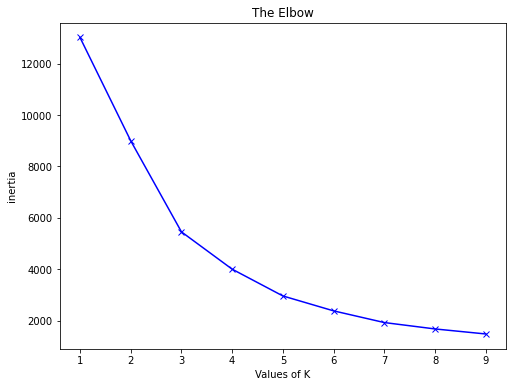

In [21]:
# elbow plot
plt.figure(figsize=(8,6))
plt.plot(k_range, inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('inertia')
plt.title('The Elbow')
plt.show()

It seems that the optimal K for the KMeans is **3**

In [22]:
# segment the customer into 3 groups
km_model = KMeans(n_clusters=3)
kmean_clusters = km_model.fit_predict(rfm_numeric_standarized)

In [23]:
# assign each customer to his cluster
rfm['kmean_clusters'] = kmean_clusters
rfm.head()

,CustomerID,montery_value,frequency,recency,kmean_clusters
0,12346.0,77183.60,1,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


### DBSCAN

In [24]:
# density based
dbscan_model = DBSCAN(eps=3, min_samples=2)
dbscan_clusters = dbscan_model.fit_predict(rfm_numeric_standarized)

# assign each customer to his cluster
rfm['dbscan_clusters'] = dbscan_clusters
rfm.head()

,CustomerID,montery_value,frequency,recency,kmean_clusters,dbscan_clusters
0,12346.0,77183.60,1,325,0,-1
1,12347.0,4310.00,182,1,1,0
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,0,0


### Hirarchal-Clustering

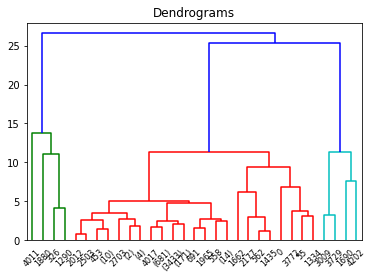

In [25]:
# agglomerative clustering
tree = hierarchy.linkage(rfm_numeric_standarized, method='average')
# agglo_clusters = agglo_model.fit_predict(rfm_numeric_standarized)

plt.figure()
plt.title("Dendrograms")
  
# Dendrogram plotting using linkage matrix
dendrogram = hierarchy.dendrogram(tree, truncate_mode='level', p=6)

In [26]:
# assign each customer to his cluster
agglo_clusters = cut_tree(tree, n_clusters=3).reshape(-1,)
rfm['agglo_clusters'] = agglo_clusters
rfm.head()

,CustomerID,montery_value,frequency,recency,kmean_clusters,dbscan_clusters,agglo_clusters
0,12346.0,77183.60,1,325,0,-1,0
1,12347.0,4310.00,182,1,1,0,0
2,12348.0,1797.24,31,74,1,0,0
3,12349.0,1757.55,73,18,1,0,0
4,12350.0,334.40,17,309,0,0,0


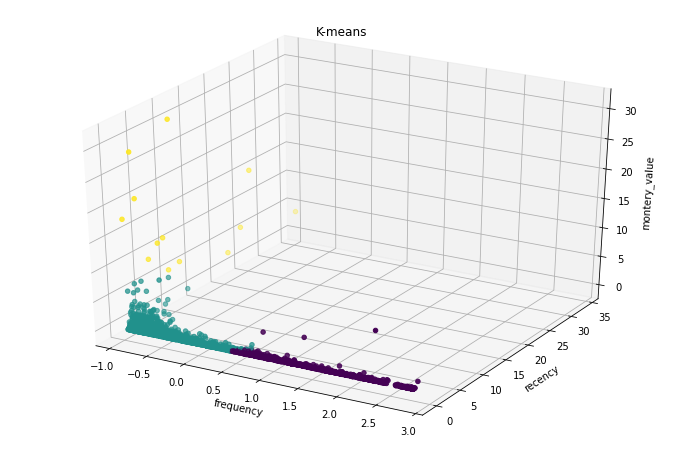

In [27]:
# K-means visualization
fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection = '3d')

xdata = rfm_numeric_standarized['recency']
ydata = rfm_numeric_standarized['frequency']
zdata = rfm_numeric_standarized['montery_value']

ax.scatter3D(xdata, ydata, zdata, c=km_model.labels_)

ax.set_xlabel('frequency')
ax.set_ylabel('recency')
ax.set_zlabel('montery_value')
ax.set_title('K-means')

plt.show()

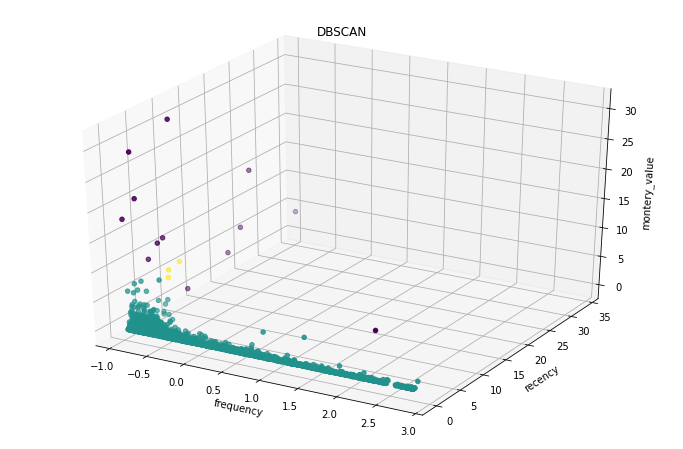

In [28]:
# DBSCAN visualization
fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection = '3d')

xdata = rfm_numeric_standarized['recency']
ydata = rfm_numeric_standarized['frequency']
zdata = rfm_numeric_standarized['montery_value']

ax.scatter3D(xdata, ydata, zdata, c=dbscan_model.labels_)

ax.set_xlabel('frequency')
ax.set_ylabel('recency')
ax.set_zlabel('montery_value')
ax.set_title('DBSCAN')

plt.show()

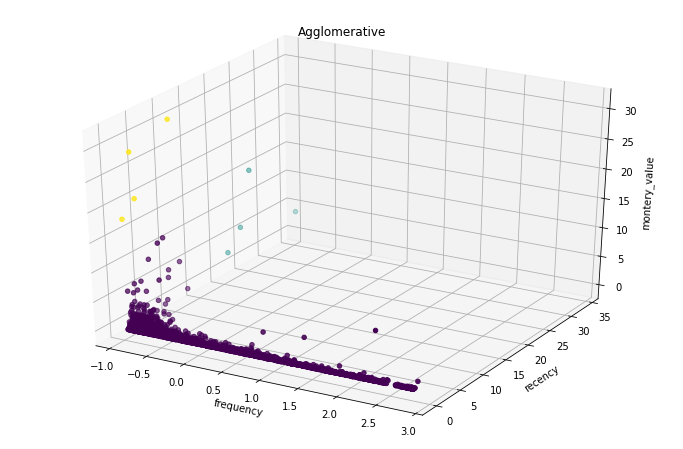

In [29]:
# Agglomerative visualization
fig = plt.figure(figsize=(12, 8))
agglo_labels = rfm['agglo_clusters']
ax = plt.axes(projection = '3d')

xdata = rfm_numeric_standarized['recency']
ydata = rfm_numeric_standarized['frequency']
zdata = rfm_numeric_standarized['montery_value']

ax.scatter3D(xdata, ydata, zdata, c=agglo_labels)

ax.set_xlabel('frequency')
ax.set_ylabel('recency')
ax.set_zlabel('montery_value')
ax.set_title('Agglomerative')

plt.show()